# About

![prjpic](doc/media_main/story.png)

This is the main demo of this repo, it is about a concept study on the MIMII dataset to detect anomalies of machines or machine parts like fans, slider, pump and valves by means of classic machine learning and deep learning methods.

In runs through the essentials to demonstrate the steps
* feature extraction
* indvitual model training 
* ensamble building and varfication
* summery and scores

# Imports

In [1]:
#===============================================
# Basic Imports
BASE_FOLDER = './'
TARGET_FOLDER_FE = r'\dataset\extdia_v1_essential' # output folder for ffeat. extraction
# import the repo-local utility py files
%run -i utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i utility\modeling\JupyterLoad_modeling.py

# feature extraction diagram
%run -i feature_extraction_diagrams\extdia_v1_essential
%run -i utility\extractor_batch.py

# helper
from tqdm.auto import tqdm
import glob
import gc

# sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

feat_ext_folder = os.path.abspath(BASE_FOLDER + TARGET_FOLDER_FE)

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe
load # extractor diagram V1 essential
load extractor_batch


## Utility wrapper functions

In [2]:
def feat_ext_process_set(FileFindDict, main_channel=0, sporadic=False, augment=False,FileCountLimit=None, n_jobs=4):
    
    if sporadic:
        dt = 1 # 1 means time slicing 
    else:
        dt = 0
        
    if augment:
        ag = 0 # augment only normal operation
    else:
        ag = -2 # not existing class = no augment
        
    extractor_batch(base_folder= BASE_FOLDER, 
                    target_folder=TARGET_FOLDER_FE, 
                    extdia = extdia_v1_essential, 
                    FileFindDict = FileFindDict,
                    n_jobs = n_jobs,
                    target_class_map = {'abnormal':1, 'normal': 0},
                    FileCountLimit = FileCountLimit,
                    datset_folder_from_base = 'dataset',
                    fHP=120,
                    DeviceType=dt,
                    main_channel = main_channel,
                    augment=ag)
    
    gc.collect()

# Feat Extraction

## Confirm feature extraction diagram

![exdia](doc/media_feature_extraction/exdia_v1_essential.png)
in order to modify the diagram go the class definition:  /feature_extraction_diagrams/extdia_v1_essential.py

### Note to the main_channel
The main channel is picking one microphone out of the 8, 
this can be seen as if the demo version is strictly in working mono
Or a DOA could be used to find the main direction see : feature_extraction_diagrams/A21_DirectionOfArrival_DOA/pyroomacustic_DOA.ipynb

In [52]:
ExampleFileFilter = {'SNR': ['6dB'],'machine': ['pump'],'ID': ['02']}
# create some 
feat_ext_process_set(ExampleFileFilter,
                    main_channel=2,
                    sporadic = False,
                    augment = True,
                    FileCountLimit= 4,
                    n_jobs=2) 


INFO:feature_extraction_batch:2020-05-11 20:12:08: Target folder will be: A:\Dev\NF_Prj_MIMII_Dataset\dataset\extdia_v1_essential
INFO:feature_extraction_batch:2020-05-11 20:12:08: Extractor diagram is fof type: <class '__main__.extdia_v1_essential'>
INFO:feature_extraction_batch:2020-05-11 20:12:08: --------------------------------------------
INFO:feature_extraction_batch:2020-05-11 20:12:08: Working on machinepart:pump SNR:6dB ID:02
INFO:feature_extraction_batch:2020-05-11 20:12:08: Files to process: 8
INFO:feature_extraction_batch:2020-05-11 20:12:08: multithread mode filling the queue


2020-05-11 20:12:08: Target folder will be: A:\Dev\NF_Prj_MIMII_Dataset\dataset\extdia_v1_essential
2020-05-11 20:12:08: Extractor diagram is fof type: <class '__main__.extdia_v1_essential'>
2020-05-11 20:12:08: --------------------------------------------
2020-05-11 20:12:08: Working on machinepart:pump SNR:6dB ID:02
2020-05-11 20:12:08: Files to process: 8
2020-05-11 20:12:08: multithread mode filling the queue


INFO:feature_extraction_batch:2020-05-11 20:12:13: multithread mode all threads done
INFO:feature_extraction_batch:2020-05-11 20:12:13: multithread mode list joined and pickled for the id
INFO:feature_extraction_batch:2020-05-11 20:12:13: total time needed for the ID: 5.6sec = 0.09min


2020-05-11 20:12:13: multithread mode all threads done
2020-05-11 20:12:13: multithread mode list joined and pickled for the id
2020-05-11 20:12:13: total time needed for the ID: 5.6sec = 0.09min
close log file



## Spot Check the output

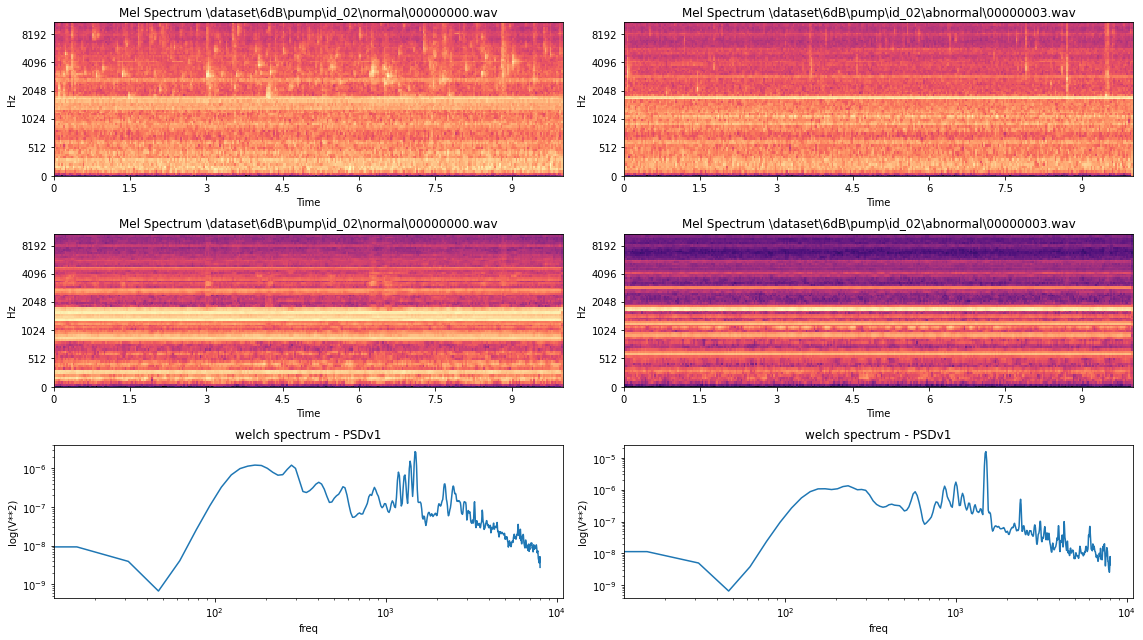

In [53]:
# This code reloads pkl files that have been stored
# in the step above - notice only created files can be loaded
# then a plot is made form n and n+1 output ports
# this cell is ment as a spot check before running the batch that might,
# take much more time !

d_MEL_den = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_den.pkl', "rb" ))
d_MEL_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_raw.pkl', "rb" ))
d_PSD_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpPSD_raw.pkl', "rb" ))
n1=2
n2=7
plt.figure(figsize=(16,9))
plt.subplot(321)
feature_extractor_from_dict(d_MEL_raw[n1],BASE_FOLDER).plot(False)
plt.subplot(322)
feature_extractor_from_dict(d_MEL_raw[n2],BASE_FOLDER).plot(False)
plt.subplot(323)
feature_extractor_from_dict(d_MEL_den[n1],BASE_FOLDER).plot(False)
plt.subplot(324)
feature_extractor_from_dict(d_MEL_den[n2],BASE_FOLDER).plot(False)
plt.subplot(325)
feature_extractor_from_dict(d_PSD_raw[n1],BASE_FOLDER).plot(True)
plt.subplot(326)
feature_extractor_from_dict(d_PSD_raw[n2],BASE_FOLDER).plot(True)
plt.tight_layout()


## Batch creation of output

In [3]:
# For demonstarion One machine 
# Create the batch
# note: increase n_jobs to max. CPUs you have use all hyperthreading cores (there is no auto detect just now)
# note: there is still a deepcopy issue you may expirence memory leack : https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/issues/58
BatchFileFilter = {'SNR': ['6dB'],'machine': ['pump'],'ID': ['02','00','04','06']}
feat_ext_process_set(BatchFileFilter,
                    main_channel=2,
                    sporadic = False,
                    augment = True,
                    n_jobs=8) 

2020-05-11 20:59:14: Target folder will be: A:\Dev\NF_Prj_MIMII_Dataset\dataset\extdia_v1_essential
2020-05-11 20:59:14: Extractor diagram is fof type: <class '__main__.extdia_v1_essential'>
2020-05-11 20:59:14: --------------------------------------------
2020-05-11 20:59:14: Working on machinepart:pump SNR:6dB ID:02
2020-05-11 20:59:14: Files to process: 1116
2020-05-11 20:59:14: multithread mode filling the queue
2020-05-11 21:12:31: multithread mode all threads done
2020-05-11 21:12:34: multithread mode list joined and pickled for the id
2020-05-11 21:12:34: total time needed for the ID: 800.51sec = 13.34min
2020-05-11 21:12:34: --------------------------------------------
2020-05-11 21:12:34: Working on machinepart:pump SNR:6dB ID:00
2020-05-11 21:12:34: Files to process: 1149
2020-05-11 21:12:34: multithread mode filling the queue


2020-05-11 21:27:50: multithread mode all threads done
2020-05-11 21:27:55: multithread mode list joined and pickled for the id
2020-05-11 21:27:55: total time needed for the ID: 920.69sec = 15.34min
2020-05-11 21:27:55: --------------------------------------------
2020-05-11 21:27:55: Working on machinepart:pump SNR:6dB ID:04
2020-05-11 21:27:55: Files to process: 802
2020-05-11 21:27:55: multithread mode filling the queue


2020-05-11 21:39:32: multithread mode all threads done
2020-05-11 21:39:34: multithread mode list joined and pickled for the id
2020-05-11 21:39:34: total time needed for the ID: 699.52sec = 11.66min
2020-05-11 21:39:34: --------------------------------------------
2020-05-11 21:39:34: Working on machinepart:pump SNR:6dB ID:06
2020-05-11 21:39:34: Files to process: 1138
2020-05-11 21:39:34: multithread mode filling the queue


2020-05-11 21:58:11: multithread mode all threads done
2020-05-11 21:58:17: multithread mode list joined and pickled for the id
2020-05-11 21:58:17: total time needed for the ID: 1122.66sec = 18.71min
close log file


# Modeling

## stochstic training

## pseudo supervised training

In [42]:
# Define Training Task list for the pipe
diagram = 'extdia_v1_essential'
machines = ['pump']
SNRs = ['6dB'] #, 'min6dB']
IDs = ['02','00','04','06']

features = [#('MEL_den', {'function':'frame', 'frames':3})
            #,('MEL_raw', {'function':'frame', 'frames':3})
            ('PSD_raw', {'function':'flat'})
           ]
tasks = []
for machine in machines:
    for SNR in SNRs:
        for ID in IDs:
            for feature in features:
                #print(machine,SNR,ID,feature)
                path = glob.glob(BASE_FOLDER \
                    + '/dataset/{}/{}{}{}_EDiaV1*aug0'.format(diagram, machine, SNR, ID) 
                    + "*pandaDisc*.pkl", recursive=True)[0]
                d = {
                'path_descr': path,
                'feat':feature[1], 
                'feat_col':feature[0], 
                'SNR':SNR, 
                'machine':machine, 
                'ID':ID,
                'BASE_FOLDER':BASE_FOLDER}
                tasks.append(d)
                


In [44]:
tasks

[{'path_descr': './/dataset/extdia_v1_essential\\pump6dB04_EDiaV1HPaug0_pandaDisc.pkl',
  'feat': {'function': 'flat'},
  'feat_col': 'PSD_raw',
  'SNR': '6dB',
  'machine': 'pump',
  'ID': '04',
  'BASE_FOLDER': './'}]

## Train SVM

In [49]:
# Preprocessing pipe
preprocessing = [
    (StandardScaler, {})
]

# uni_Model define
# See also \utility\modeling\pseudo_supervised_models.py form more uni models 
# also on how to use grid search (here not needed yet hence no augmentation feedback)
modeling = (uni_svm, {'C': 0.1, 'degree':3,'kernel':'rbf'})

# setup pipe only for one model and one preprocessing .. append with more models if
# needed. 
pipes = [Pipe(preprocessing, modeling, pseudo_sup=True) for i in range(len(tasks))]

tasks_failed = []
for pipe, task in tqdm(zip(pipes, tasks), total=len(tasks)):
    try:
        pipe.run_pipe(task)
    except:
        tasks_failed.append(task)
        print('Task failed')

.//dataset/extdia_v1_essential\pump6dB04_EDiaV1HPaug0_pandaDisc.pkl --> Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
0.9906720124501938
model fitted successfully

...evaluating model
evaluation successfull, roc_auc: 0.9975999999999999
pipe saved to pickle



## auto encoder training

# Ensamble Blending

# Summery/ Results